**Implementación de un algoritmo genético simple para representación real**

420.43039999999996
[-2.048, -2.048] [2.048, 2.048] 30


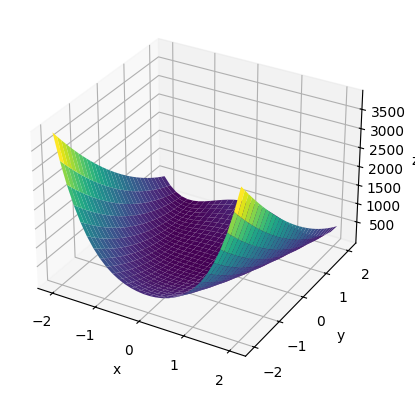

In [6]:
#funciones de prueba
import math
import numpy as np
import matplotlib.pyplot as plt

def rosenbrock(x):
	#Maximize
	#ranges x1 = [ 0, -2.048] x2 = [0, 2.048]
	#optimal value x* = -,- f(x*) = -
  f = 0
  for i in range(len(x)-1):
    f += 100*(x[i+1]-x[i]**2)**2 + (1-x[i])**2
  return f

def ackley(x):
  #Minimize
  #ranges x1 = [-32.768, 32.768] x2 = [-32.768, 32.768]
  #optimal value x* = 0,0 f(x*) = 0
  f = 0
  for i in range(len(x)):
    f += (-20*math.exp(-0.2*math.sqrt(0.5*(x[i]**2)))) - math.exp(0.5*math.cos(2*math.pi*x[i])) + math.e + 20
  return f


def plotFunction(limInf, limSup, n):
  print(limInf, limSup, n)
  x1 = np.linspace(limInf[0], limSup[0], n)
  x2 = np.linspace(limInf[1], limSup[1], n)
  X, Y = np.meshgrid(x1, x2)
  FX = rosenbrock([X, Y])

  fig = plt.figure()
  ax = plt.axes(projection='3d')
  #ax.contour3D(X, Y, FX, 50, cmap='binary')
  ax.plot_surface(X, Y, FX, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')



if __name__ == "__main__":
  #evalua valores en las funciones de prueba
  print(rosenbrock([ 0, -2.048]))

  #grafica la función de prueba
  plotFunction([-2.048, -2.048], [2.048,2.048], 30)


**Estructura básica de un algoritmo genético**

In [7]:
import random
from operator import itemgetter
from statistics import mean
import matplotlib.pyplot as plt

def poblacionInicial(tam, numVar, limInf, limSup):
  poblacion = []
  for i in range(0, tam):
    X = []
    for j in range(0, numVar):
      X.append(random.uniform(limInf[j], limSup[j]))

    fx = calculaAptitud(X)
    poblacion.append([X, fx])
  return poblacion

def calculaAptitud(X):
  return rosenbrock(X)

# sleccion por torneo probabilistico
def defineParejas(tamPop, padres):
  #ordenamos padres de forma aleatoria
  parejas1 = random.sample(padres, len(padres))
  #generamos a la segunda pareja
  parejas2 = random.sample(padres, len(padres))
  #eliminamos al menos apto de las parejas
  parejas1 = torneoProbabilistico(tamPop, parejas1)
  parejas2 = torneoProbabilistico(tamPop, parejas2)
  #ahora generamos los padres, que son los indices de los padres
  indices = []
  for i in range(0, len(parejas1)):
    indices.append(padres.index(parejas1[i]))
    indices.append(padres.index(parejas2[i]))
  return indices


def torneoProbabilistico(tamTorneo, parejas):
  pseleccion = 0.75#probabilidad de seleccion
  for i in range(0, tamTorneo, 2):
    #generamos un numero aleatorio entre 0 y 1 que es la probabilidad de seleccion
    seleccion = random.uniform(0,1)
    if i+1 >= len(parejas)-1:
      #no hace nada
      pass
    elif seleccion <= pseleccion:
    # elif True:
      #selecciona el mejor individuo en minimizacion
      if parejas[i][1] < parejas[i+1][1]:
        #elimina al individuo de menor aptitud
        parejas.pop(i+1)
      else:
        parejas.pop(i)
    else:
      #selecciona el peor individuo en minimizacion
      if parejas[i][1] > parejas[i+1][1]:
        #elimina al individuo de mayor aptitud
        parejas.pop(i+1)
      else:
        parejas.pop(i)
  return parejas

#cruza de dos puntos
def cruza(p1, p2):
  #genera dos puntos de cruza
  punto1 = random.randint(0, len(p1)-1)
  punto2 = random.randint(0, len(p1)-1)
  while punto1 == punto2:
    punto2 = random.randint(0, len(p1)-1)
  if punto1 > punto2:
    punto1, punto2 = punto2, punto1
  #print("puntos de cruza", punto1, punto2)
  #genera hijos
  h1 = p1[:punto1] + p2[punto1:punto2] + p1[punto2:]
  h2 = p2[:punto1] + p1[punto1:punto2] + p2[punto2:]
  return h1, h2

#crea poblacion de descendientes
def creaHijos(pCruza, indices, padres, tamPob):
  hijos = []
  j = 0
  while j < tamPob:
    if random.uniform(0,1) <= pCruza:
      p1 = padres[indices[j]][0]
      p2 = padres[indices[j+1]][0]
      #print("padre1",p1)
      #print("padre2",p2)
      h1, h2 = cruza(p1, p2)
      #print("hijo1", h1)
      #print("hijo2", h2)
      hijos.append(h1)
      hijos.append(h2)
    j += 2
  return hijos


def mutacion(cromosoma, delta, porcMuta):
  nuevo_crom =[]
  for gen in cromosoma:
    if random.uniform(0,1) <= porcMuta:
      if random.uniform(0,1) <= 0.5:
        gen += delta
      else:
        gen -= delta
    nuevo_crom.append(gen)
  return nuevo_crom

def reparacion(cromosoma, limInf, limSup):
  for i in range(0, len(cromosoma)):
    if cromosoma[i] < limInf[i]:
      cromosoma[i] = limInf[i]
    elif cromosoma[i] > limSup[i]:
      cromosoma[i] = limSup[i]
  return cromosoma


def algoritmoGenetico(nVariables, limInf, limSup, tamPoblacion, porcCruza, porcMuta, generaciones):
  #genera poblacion inicial
  padres = poblacionInicial(tamPoblacion, nVariables, limInf, limSup)
  print("Poblacion inicial ", padres)
  print("===========================")
  mejores = []
  peores = []
  promedio = []
  i = 0
  epsilon = 0.0001
  #repite mientras no se alcance criterio de paro
  for i in range(0, generaciones):
    #crea parejas de padres
    indices = defineParejas(tamPoblacion,padres)
    print("Parejas", indices)
    #aplica operador de cruza por cada pareja (para generar hijos)
    hijos = creaHijos(porcCruza, indices, padres, tamPoblacion)
    #print("longitud de hijos", len(hijos))
    #print(hijos)

    #aplica operador de mutacion
    hijos2 = []
    for hijo in hijos:
      mutado = mutacion(hijo, 0.1, porcMuta)
      hijos2.append([mutado, calculaAptitud(mutado)])
    #print("hijos mutados", hijos2)

    #unir padres y descendientes
    nuevaPoblacion = padres + hijos2
    print("longitud de padres e hijos", len(nuevaPoblacion))
    print("nueva poblacion", nuevaPoblacion)

    #selecciona los sobrevivientes
    sobrevivientes = sorted(nuevaPoblacion, key=itemgetter(1), reverse=False)
    print("ordenada", end=" ")
    for ind in sobrevivientes:
      print(ind[1], end=" ")
    padres = sobrevivientes[0: tamPoblacion]
    #hacemos reparacion de los padres
    for i in range(0, len(padres)):
      padres[i][0] = reparacion(padres[i][0], limInf, limSup)
    print("nuevos padres (sobrevivientes)", padres)
    #registra los valores del mejor y peor individuo por generación
    mejores.append(padres[0][1])
    peores.append(padres[-1][1])
    #calcula la aptitud promedio de la población en cada generación
    prom = 0
    for p in padres:
      prom += p[1]
    promedio.append(prom/len(padres))
    #criterio de paro
    if abs(peores[-1] - mejores[-1]) <= epsilon:
      break

  print("mejor solucion", padres[0])
  #print("MEJORES", mejores)
  #print("PEORES", peores)
  #print("PROMEDIO", promedio)

  return mejores, peores, promedio


def grafica(mejores, peores, promedio, generaciones):
  x = list(range(1, len(mejores)+1))
  print(x)
  print(mejores)
  plt.scatter(x, mejores, color='green', label='mejor', marker='*')
  plt.plot(x, mejores, color='green', marker='*')
  plt.scatter(x, peores, color='red', label='peor', marker='v')
  plt.plot(x, peores, color='red', marker='v')
  plt.scatter(x, promedio, color='blue', label='promedio', marker='.')
  plt.plot(x, promedio, color='blue', marker='.')
  plt.legend()
  plt.xlabel('Generaciones')
  plt.ylabel('Aptitud')
  plt.title("Grafica de convergencia")
  plt.show()


In [8]:
#parametros de entrada
nVariables = 1
limInf=[-2.045,-2.045, -2.045,-2.045, -2.045,-2.045, -2.045,-2.045,-2.045,-2.045]
limSup=[2.048,2.048,2.048,2.048,2.048,2.048,2.048,2.048,2.048,2.048]
# el tamaño de la población debe ser un numero par
tamPoblacion = 100
porcCruza = 0.9
porcMuta = 0.1
generaciones = 100

random.seed(123)
mejores, peores, promedio = algoritmoGenetico(nVariables, limInf, limSup, tamPoblacion, porcCruza, porcMuta, generaciones)
grafica(mejores, peores, promedio, generaciones)


Poblacion inicial  [[[-1.8306757899030848], 0], [[-1.6881449288998658], 0], [[-0.3781594612970596], 0], [[-1.6041829383969688], 0], [[1.643607007456286], 0], [[-1.8888370446431944], 0], [[0.14967494985886276], 0], [[-0.6853148199998804], 0], [[1.4425905312779062], 0], [[-1.391501810216977], 0], [[-0.6647722224517352], 0], [[-0.6787713567836859], 0], [[-1.0415463981454176], 0], [[-2.038162424200241], 0], [[-0.259323177551511], 0], [[-1.6863979455215192], 0], [[0.40097460814934527], 0], [[-1.7589935967475663], 0], [[-0.7538264204991114], 0], [[-0.21001924789967918], 0], [[1.660796683800454], 0], [[-1.6653146502778196], 0], [[-1.463077461281866], 0], [[1.188764058960575], 0], [[-1.9580811550740629], 0], [[1.6843391933336829], 0], [[0.30195929469203486], 0], [[-0.9590382603644214], 0], [[1.384269477690685], 0], [[1.1016769014355727], 0], [[-0.6392093866676369], 0], [[1.2355255481582912], 0], [[-1.198311907563606], 0], [[0.44723803969793474], 0], [[0.11231777919667829], 0], [[1.267622581367

KeyboardInterrupt: 